<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12: Near-zero Gradients Explainer
This notebook begins a whole new idea - that I can find direct explanations for computed gradients, and offer explicit explanations for gradients trending towards zero.

Specifically, given sufficient activation, weights, and gradient information surrounding a particular layer at a particular point during training, I can re-execute all of the steps that occurred to calculate the gradients. In so doing, I can break down the steps and identify which set of steps led to zero and near-zero gradients.

In practice I don't have 100% of the information needed, and I also cannot support the same level of flexibility that TF does with its polymorphic layer abstraction. But there's still a lot that can be done, because:
* most layers fall into a very small set of common layers, eg: deep, convolution.
* I can design the "explainer" to degrade gracefully, presenting as much information as it can obtain.

In [59]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
import matmul_explainer as me
from importlib import reload
reload(tot)
reload(te)
reload(me)

HEAD is now at c7158dd describe_tensor_units_near_zero_explanation() plus both now return ordered lists
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 3), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 2.37 MiB | 7.87 MiB/s, done.
From https://github.com/malcolmlett/ml-learning
   c7158dd..21ccf10  main       -> origin/main
Updating c7158dd..21ccf10
Fast-forward
 Learning_visualisations_v12.ipynb | 1734 ++++++++++++++++++++++++++++++++-------------------------
 train_explainer.py                |   32 +-
 2 files changed, 988 insertions(+), 778 deletions(-)


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [2]:
g = tot.GradientHistoryCallback()
type(g).__name__

'GradientHistoryCallback'

In [3]:
type(g).__module__

'train_observability_toolkit'

In [4]:
tot.GradientHistoryCallback.__module__

'train_observability_toolkit'

In [5]:
type(None).__name__

'NoneType'

In [6]:
import train_observability_toolkit_test
import train_explainer_test
import matmul_explainer_test
reload(matmul_explainer_test)
reload(train_explainer_test)
reload(train_observability_toolkit_test)
reload(tot)
reload(me)
reload(te)
train_observability_toolkit_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


In [7]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


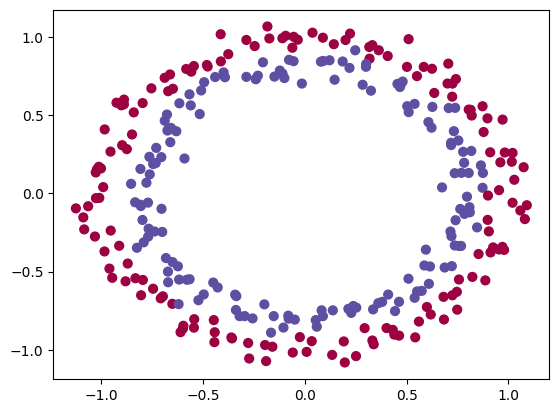

In [8]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [9]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Training with Data collection
The explainer requires that we collect full data for the layer in question and those on either side.
So let's run a training sequence with detailed data collection.

We'll run for a few epochs so that we can pick an iteration that has some interesting characteristics. Also, for this very simple model, we don't have a good idea in advance which layer might lead to some interesting results, and it isn't very big, so we'll just collect all data across all layers.



In [10]:
# This will take a couple of minutes to run
reload(tot)
collection_sets = [{'include_non_trainable': True}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=20, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, output_gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_55']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_55']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     2 - 4.35s/epoch: loss: 0.6673  
Epoch     4 - 1.91s/epoch: loss: 0.6662  
Epoch     6 - 1.26s/epoch: loss: 0.6679  
Epoch     8 - 1.27s/epoch: loss: 0.6496  
Epoch    10 - 1.27s/epoch: loss: 0.6565  
Epoch    12 - 1.07s/epoch: loss: 0.6519  
Epoch    14 - 1.12s/epoch: loss: 0.6476  
Epoch    16 - 2.18s/epoch: loss: 0.6359  
Epoch    18 - 778.62ms/epoch: loss: 0.6374  
Epoch    20 - 776.99ms/epoch: loss: 0.6201  
Total training time: 32.12 secs


Now let's take a look at the summary statistics and find a layer of interest and a point in time that's interesting.

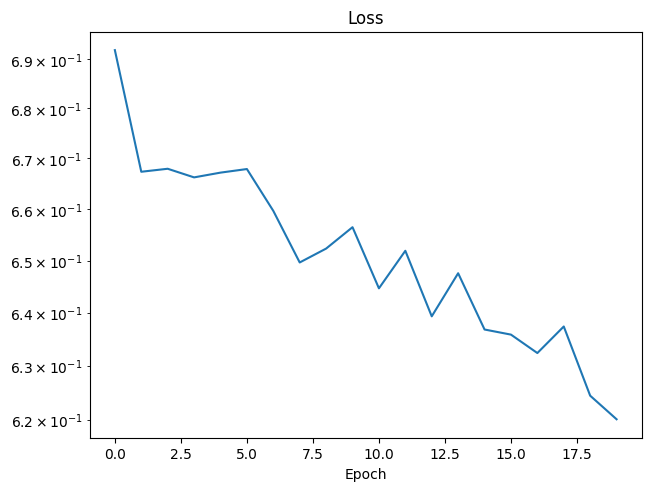

In [11]:
plot_fit(history)

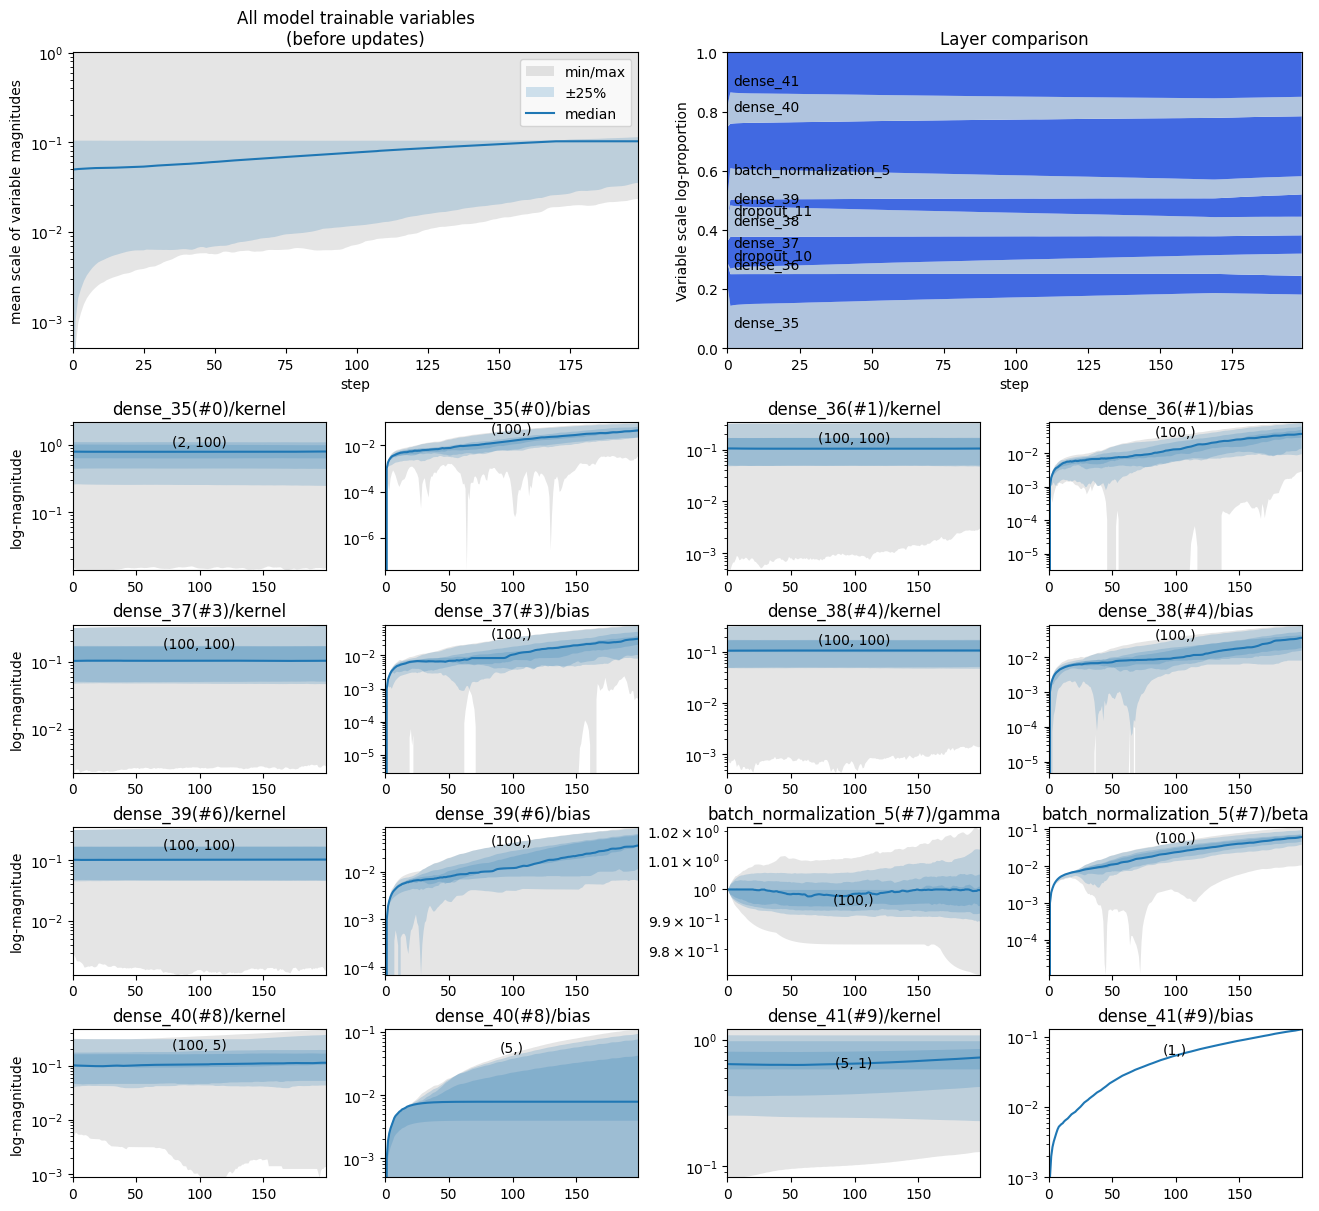

In [12]:
tot.plot_variable_history(variables, magnitudes=True)

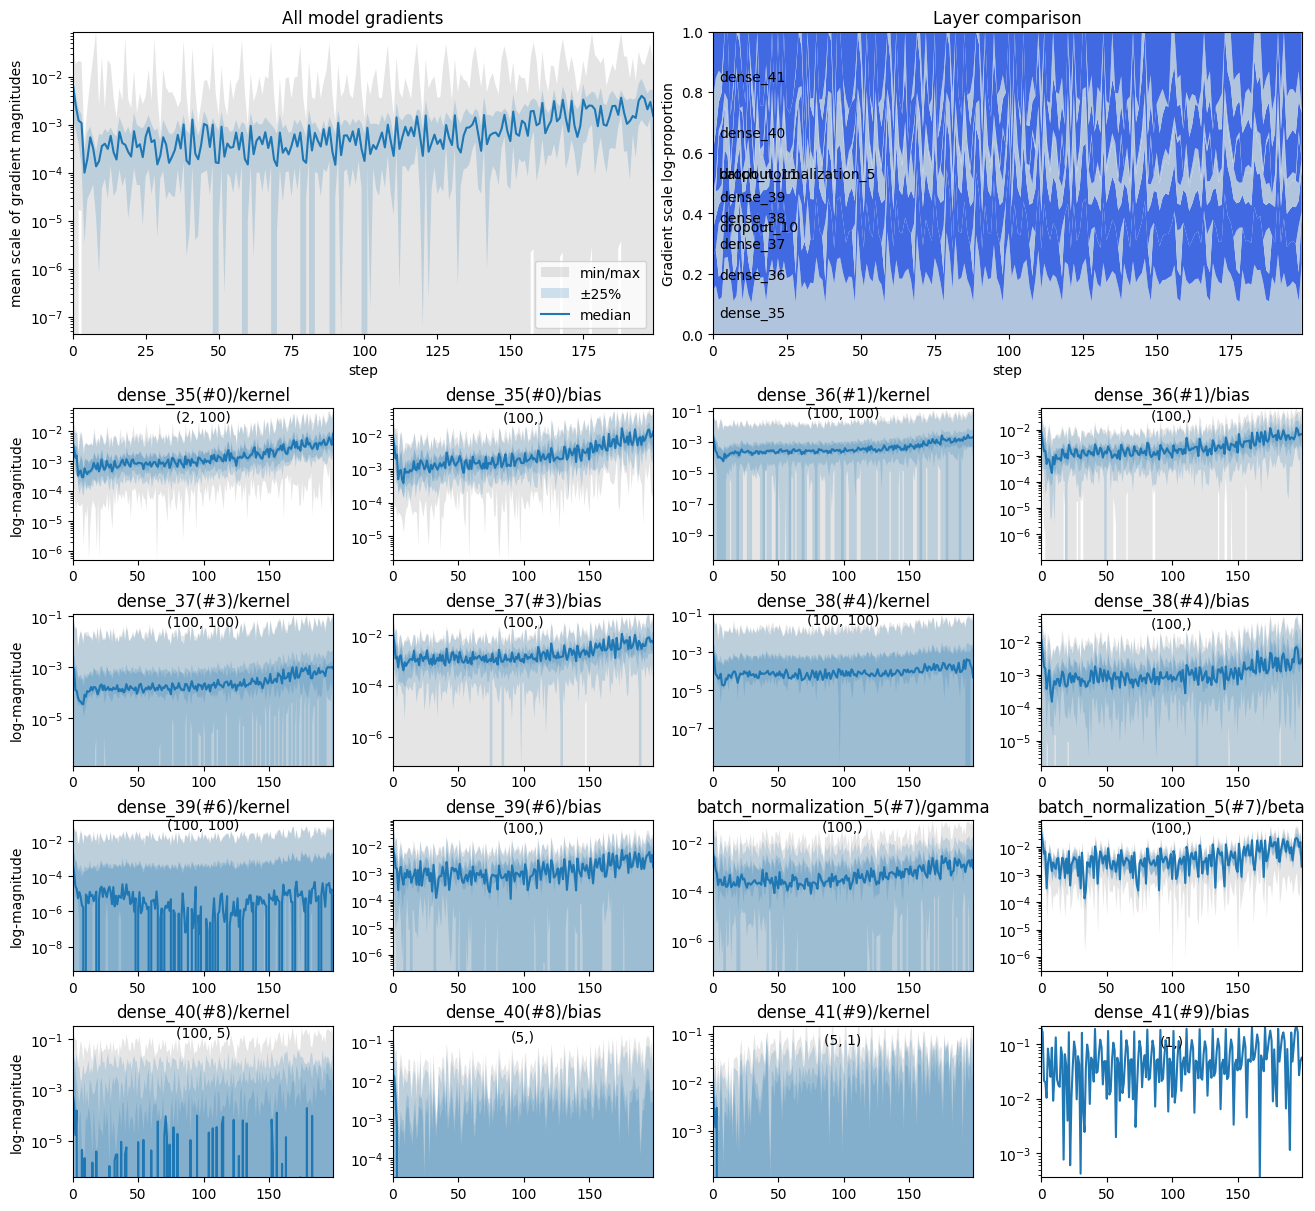

In [13]:
tot.plot_gradient_history(gradients, magnitudes=True)

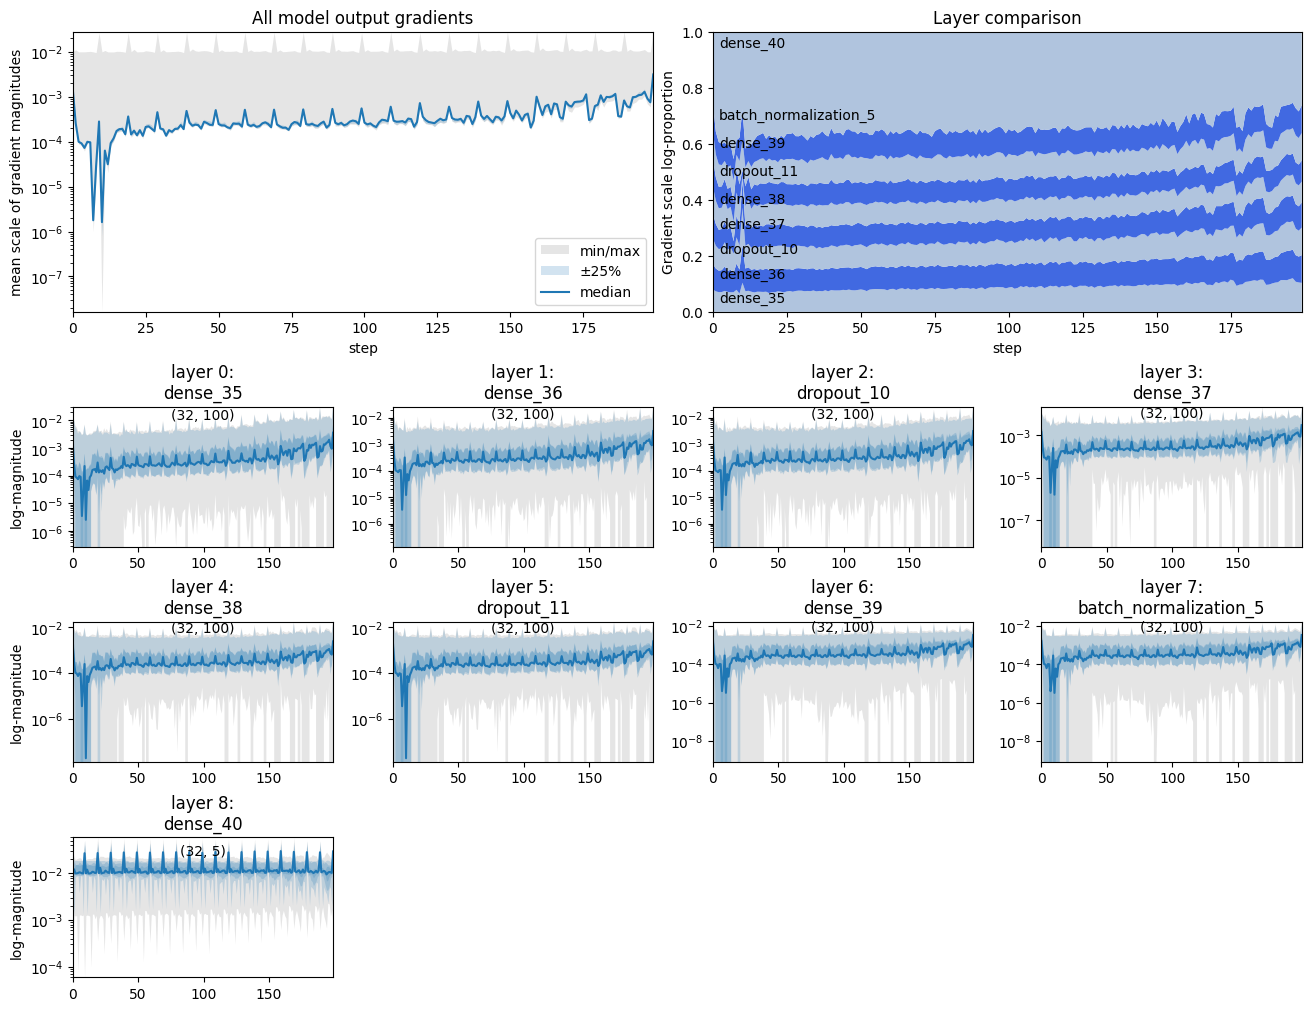

In [14]:
tot.plot_output_gradient_history(output_gradients, magnitudes=True)

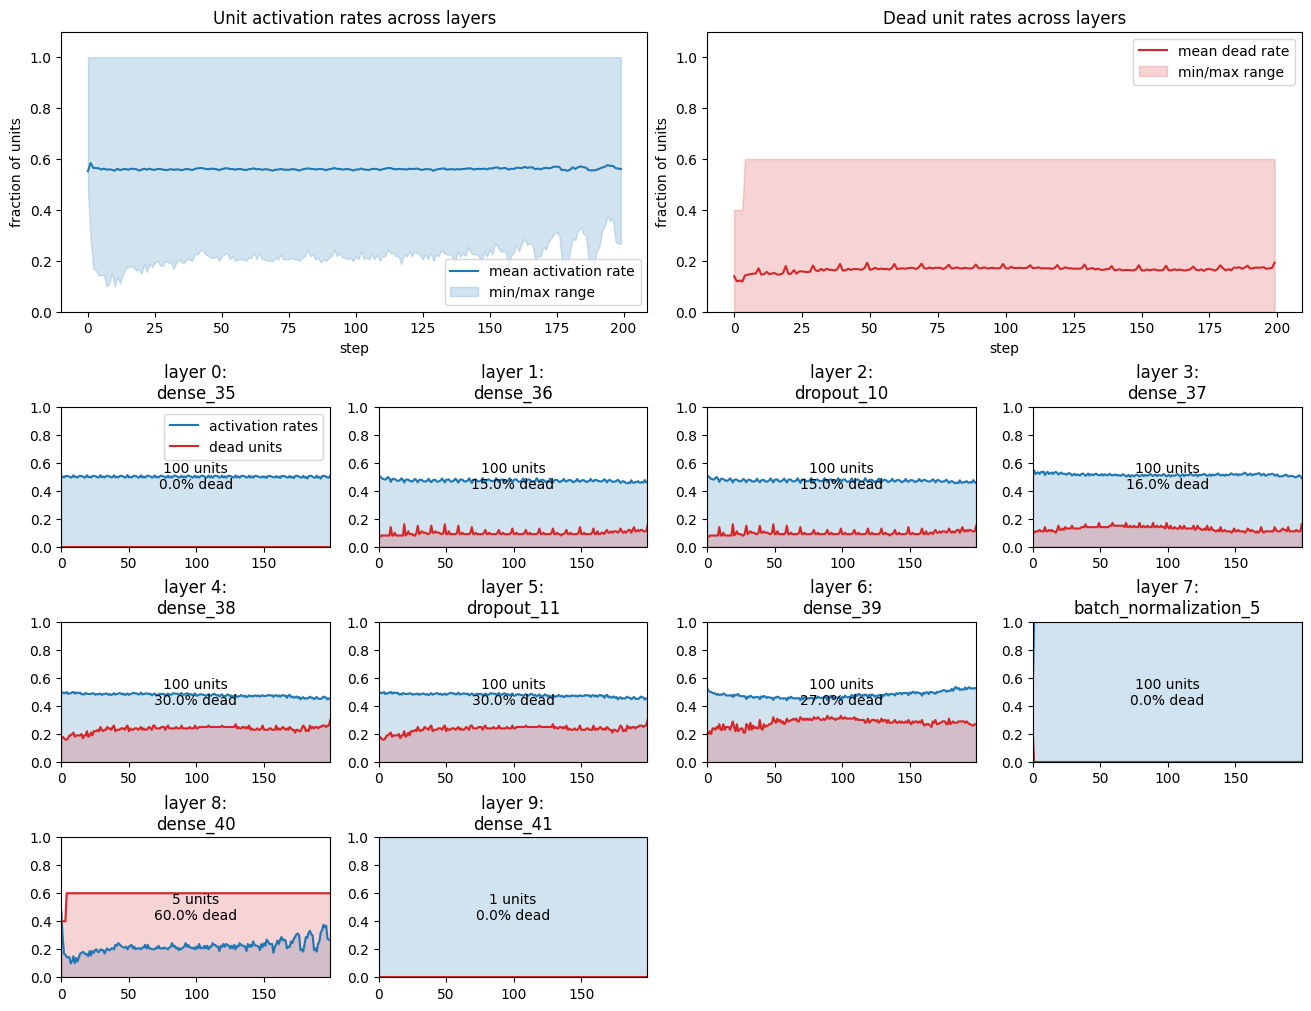

In [15]:
tot.plot_activity_rate_history(activity)

## Point of interest selection
From the above we can conclude that:
* This particular run didn't produce anything very exciting.
* The variable #6 (zero-based), the kernel of layer #4, experienced some zero gradients briefly during its first 200 iterations.

Let's narrow down on an iteration of interest.

In fact, as we'll see, the graphs above are not yet indicating the situation well enough. That variable actually has a large number of its individual values that stay at exactly zero throughout training.

In [16]:
selected_layer_idx = 3
selected_var_idx = 5
selected_iteration = 50
prev_layer_idx = 1
prev_var_idx = 2
next_layer_idx = 4
next_var_idx = 7

In [17]:
print(f"Previous layer: #{prev_layer_idx} = {model.layers[prev_layer_idx].name}, variable: #{prev_var_idx} = {model.variables[prev_var_idx].path}")
print(f"Target layer:   #{selected_layer_idx} = {model.layers[selected_layer_idx].name}, variable: #{selected_var_idx} = {model.variables[selected_var_idx].path}")
print(f"Next layer:     #{next_layer_idx} = {model.layers[next_layer_idx].name}, variable: #{next_var_idx} = {model.variables[next_var_idx].path}")

Previous layer: #1 = dense_36, variable: #2 = sequential_5/dense_36/kernel
Target layer:   #3 = dense_37, variable: #5 = sequential_5/dense_37/kernel
Next layer:     #4 = dense_38, variable: #7 = sequential_5/dense_38/kernel


In [18]:
gradients.gradient_stats[selected_var_idx]

,0.0,12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0
0,-0.064000,-0.004469,-0.001017,-0.000013,0.0,0.000000,0.000965,0.004352,0.099813
1,-0.046961,-0.003328,-0.000814,-0.000022,0.0,0.000000,0.000442,0.002645,0.064550
2,-0.029660,-0.000873,-0.000104,0.000000,0.0,0.000000,0.000123,0.000954,0.037815
3,-0.036899,-0.001222,-0.000117,0.000000,0.0,0.000000,0.000051,0.000667,0.033722
4,-0.005640,-0.000407,-0.000062,0.000000,0.0,0.000000,0.000030,0.000315,0.007188
...,...,...,...,...,...,...,...,...,...
195,-0.102891,-0.001408,-0.000056,0.000000,0.0,0.000119,0.000993,0.004528,0.097906
196,-0.086983,-0.001469,-0.000173,0.000000,0.0,0.000054,0.000983,0.004279,0.089044
197,-0.060821,-0.003708,-0.000950,-0.000044,0.0,0.000000,0.000266,0.001745,0.053525
198,-0.080802,-0.004186,-0.001036,-0.000134,0.0,0.000000,0.000095,0.001541,0.087054


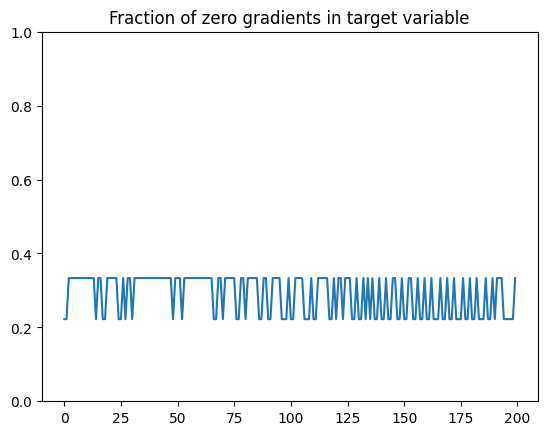

In [19]:
data = gradients.gradient_stats[selected_var_idx].to_numpy()
data = np.sum((data == 0.0), axis=-1) / data.shape[1]

plt.plot(data)
plt.title("Fraction of zero gradients in target variable")
plt.ylim([0.0, 1.0])
plt.show()

Let's take a closer look at the raw values at our selected iteration...

raw_weights:          (100, 100)
raw_activations:      (32, 100)
raw_gradients:        (100, 100)
raw_output_gradients: (32, 100)


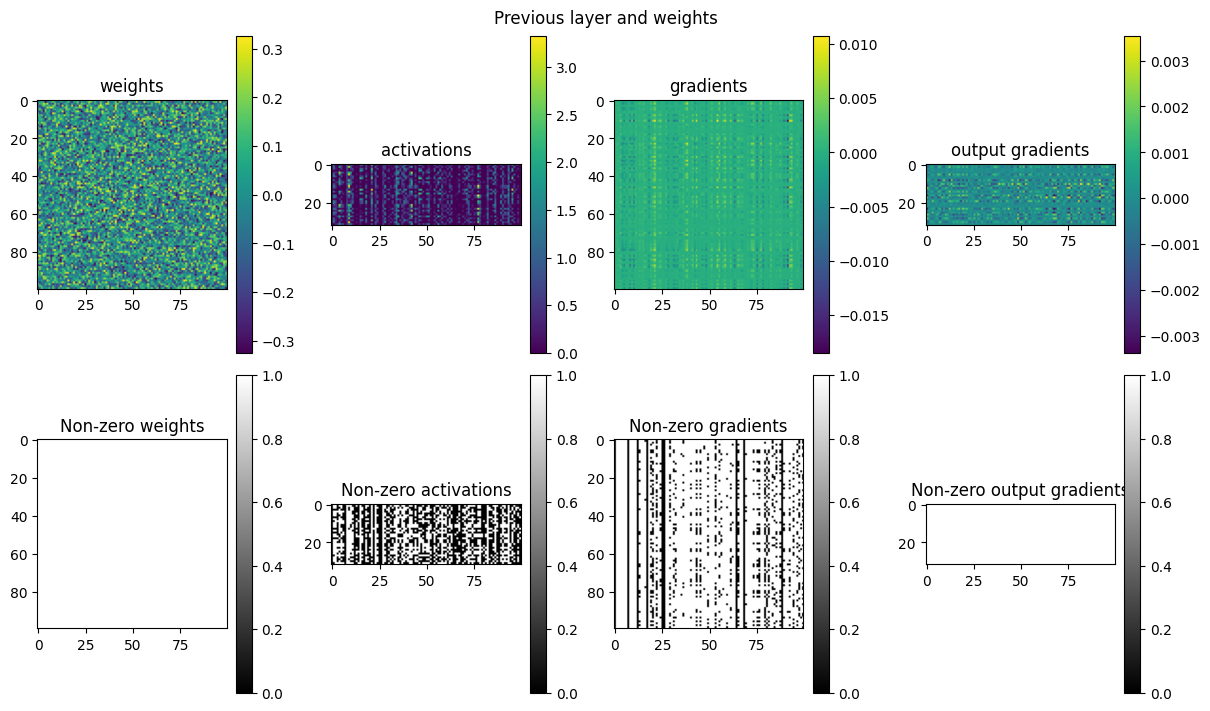

raw_weights:          (100, 100)
raw_activations:      (32, 100)
raw_gradients:        (100, 100)
raw_output_gradients: (32, 100)


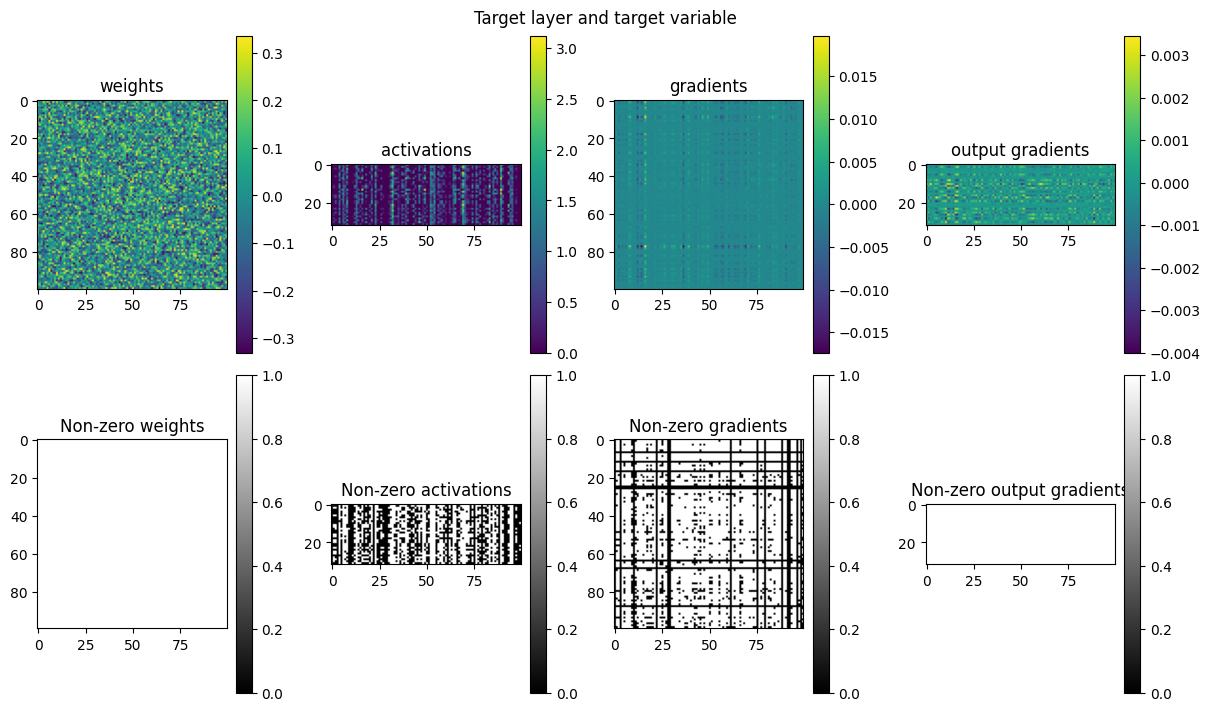

raw_weights:          (100, 100)
raw_activations:      (32, 100)
raw_gradients:        (100, 100)
raw_output_gradients: (32, 100)


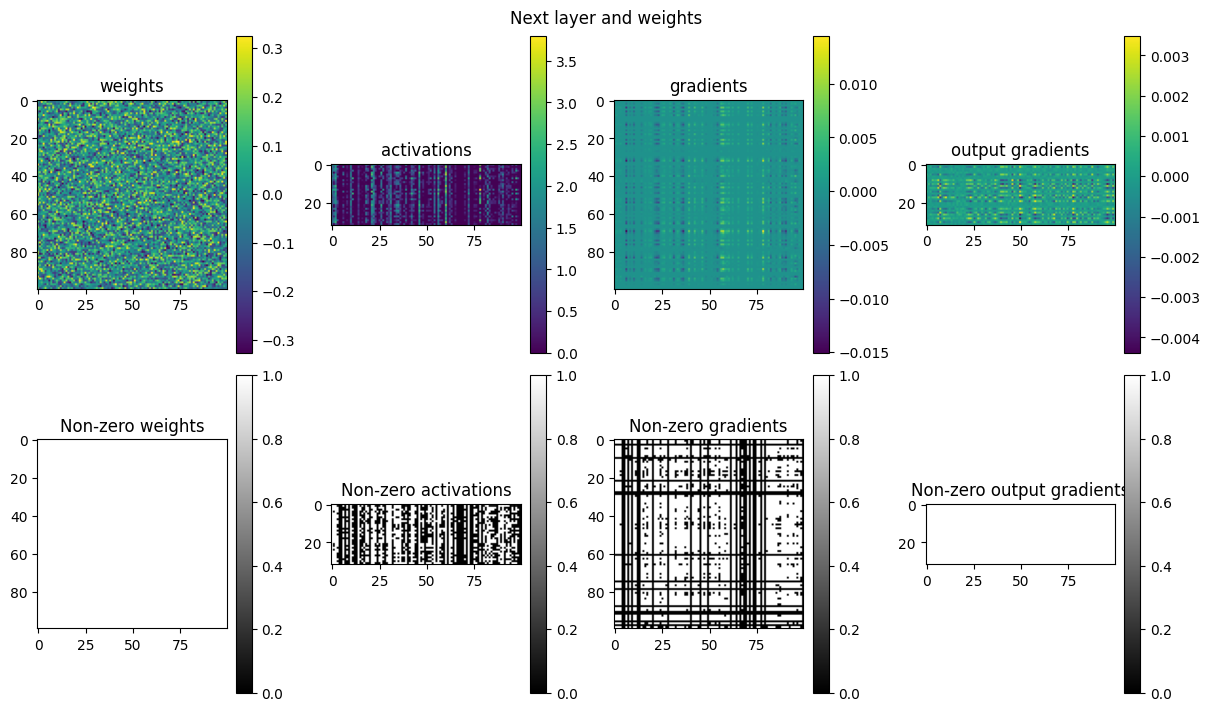

In [20]:
def plot_stuff(title, l_idx, var_idx, it_idx):
  raw_weights = variables.variables[var_idx][it_idx]
  raw_activations = activity.layer_outputs[l_idx][it_idx]
  raw_gradients = gradients.gradients[var_idx][it_idx]
  raw_output_gradients = output_gradients.gradients[l_idx][it_idx]
  print(f"raw_weights:          {raw_weights.shape}")
  print(f"raw_activations:      {raw_activations.shape}")
  print(f"raw_gradients:        {raw_gradients.shape}")
  print(f"raw_output_gradients: {raw_output_gradients.shape}")

  fig = plt.figure(figsize=(12,7), layout='constrained')
  fig.suptitle(title)

  plt.subplot(2,4,1)
  plt.title('weights')
  plt.imshow(raw_weights)
  plt.colorbar()

  plt.subplot(2,4,2)
  plt.title('activations')
  plt.imshow(raw_activations)
  plt.colorbar()

  plt.subplot(2,4,3)
  plt.title('gradients')
  plt.imshow(raw_gradients)
  plt.colorbar()

  plt.subplot(2,4,4)
  plt.title('output gradients')
  plt.imshow(raw_output_gradients)
  plt.colorbar()

  plt.subplot(2,4,5)
  plt.title('Non-zero weights')
  plt.imshow(raw_weights != 0, cmap='gray', vmin=0.0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,4,6)
  plt.title('Non-zero activations')
  plt.imshow(raw_activations != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,4,7)
  plt.title('Non-zero gradients')
  plt.imshow(raw_gradients != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,4,8)
  plt.title('Non-zero output gradients')
  plt.imshow(raw_output_gradients != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.show()

plot_stuff("Previous layer and weights", prev_layer_idx, prev_var_idx, selected_iteration)
plot_stuff("Target layer and target variable", selected_layer_idx, selected_var_idx, selected_iteration)
plot_stuff("Next layer and weights", next_layer_idx, next_var_idx, selected_iteration)


## Explainer implementation

In [21]:
# First, check that we can get terse top-level explanations for near-zero values in tensors and tensor outcomes
grad = gradients.gradients[selected_var_idx][selected_iteration]
W_l = variables.variables[selected_var_idx][selected_iteration]
A_0 = activity.collected_layer_outputs[selected_layer_idx-1][selected_iteration]

print(f"gradients: {te.describe_tensor_near_zero_explanation(me.tensor_classify(grad), verbose=True)}")
print(f"weights:   {te.describe_tensor_near_zero_explanation(me.tensor_classify(W_l), negatives_are_bad=True, verbose=True)}")

print()
res = np.matmul(A_0, W_l)
desc, frac = te.describe_top_near_zero_explanandum(me.matmul_classify(A_0, W_l), input_names=['A_0', 'W_l'])
descriptions, fractions = te.describe_near_zero_explanation(me.matmul_classify(A_0, W_l), input_names=['A_0', 'W_l'])
print(f"Top explanation: {frac * 100:.1f}% due to {desc}")
print(f"All:")
for desc, frac in zip(descriptions, fractions):
  print(f"  {frac * 100:.1f}% due to {desc}")

gradients: 30.6% near-zero
weights:   50.7% negative, 5.0% near-zero

Top explanation: 52.2% due to near-zero values from A_0
All:
  52.2% due to near-zero values from A_0
  54.5% due to near-zero values from either input
  5.0% due to near-zero values from W_l
  2.3% due to positive/negatives from W_l cancelling out (PP ~= PN)
  2.3% due to sums of positive/negatives from both inputs cancelling out (PP+NN ~= NP+PN)


In [65]:
# And now get full blown explanation
reload(te)
reload(me)
from train_observability_toolkit import _index_by_identity, VariableHistoryCallback, GradientHistoryCallback, LayerOutputGradientHistoryCallback, ActivityHistoryCallback
from train_explainer import _split_by_largest, _find_outbound_layers, _find_inbound_layers, _mask_near_zero, _format_threshold, UnsupportedNetworkError
from train_explainer import describe_top_near_zero_explanandum, describe_near_zero_explanation, describe_tensor_near_zero_explanation
from train_explainer import LayerHandler, get_layer_handler_for

def reload_safe_isinstance(obj, cls):
  if isinstance(obj, cls):
    return True
  obj_cls_fqn = f"{type(obj).__module__}.{type(obj).__name__}"
  cls_fqn = f"{cls.__module__}.{cls.__name__}"
  return obj_cls_fqn == cls_fqn

###
## The main function
###
def explain_near_zero_gradients(callbacks: list,
                                layer_index: int,
                                epoch=None, step=None,
                                confidence: float = 0.99,
                                threshold: float = None,
                                verbose=False):
    """
    Attempts to identify the explanation for zero and near-zero gradients in a given layer.

    Callbacks must be populated with data from a call to fit(). Callbacks must
    be populated with full raw data collection for at least the layer in question
    plus:
    - activity: also must capture raw activity for the input layers to the layer in question.

    Args:
        callbacks: List of callbacks as supplied to fit() and now populated with data.
          See above for additional requirements.
        layer_index: layer to examine
        epoch: epoch number selection from callback histories, if callbacks captured against epochs
        step: step number selection from callback histories, if callbacks captured against update steps
        confidence: confidence level for near-zero classification throughout
            Ignored for the selected layer gradients if `threshold` is set, but still used for other thresholds
        threshold: this layer gradients equal or below this magnitude are considered "near-zero".
            Not used for other thresholding.
        verbose: whether to show more detailed information.

    Usage:
    > l_idx = 35
    > variables = VariableHistoryCallback(collection_sets=[{layer_indices: l_idx}, before_updates=True)
    > activity = ActivityHistoryCallback(collection_sets=[{layer_indices: [l_idx-1, l_idx]})
    > gradients = GradientHistoryCallback(collection_sets=[{layer_indices: l_idx})
    > output_gradients = LayerOutputGradientHistoryCallback(collection_sets=[{layer_indices: l_idx})
    > fit(model, train_data, callbacks=[variables, activity, gradients, output_gradients])
    > explain_near_zero_gradients(l_idx, epoch=..., callbacks=[variables, activity, gradients, output_gradients])
    """

    # parse arguments - extract individual callbacks by type
    variables = None
    activity = None
    gradients = None
    output_gradients = None
    for cb in callbacks:
        if reload_safe_isinstance(cb, tot.VariableHistoryCallback):
            variables = cb
        elif reload_safe_isinstance(cb, tot.ActivityHistoryCallback):
            activity = cb
        elif reload_safe_isinstance(cb, tot.GradientHistoryCallback):
            gradients = cb
        elif reload_safe_isinstance(cb, tot.LayerOutputGradientHistoryCallback):
            output_gradients = cb

    # parse arguments - identify iteration number
    if epoch is not None:
        indices = np.nonzero(gradients.epochs == epoch)[0]
        if len(indices) == 0:
            raise ValueError(f"Epoch {epoch} not found in gradient history")
        iteration = indices[0]
    elif step is not None:
        indices = np.nonzero(gradients.steps == step)[0]
        if len(indices) == 0:
            raise ValueError(f"Step {step} not found in gradient history")
        iteration = indices[0]
    else:
        raise ValueError("One of epoch or step must be specified")

    # get model and identify inbound and outbound layers
    model = gradients.model
    target_layer = model.layers[layer_index]
    inbound_layer_indices = _find_inbound_layers(model, target_layer, return_type='index')
    outbound_layer_indices = _find_outbound_layers(model, target_layer, return_type='index')
    l_to_var_indices = tot.variable_indices_by_layer(model, include_trainable_only=False)
    print(f"layer: #{layer_index} = {target_layer} at iteration {iteration}")
    print(f"  inbound_layer_indices: {inbound_layer_indices}")
    print(f"  outbound_layer_indices: {outbound_layer_indices}")
    if not inbound_layer_indices:
        raise ValueError(f"Layer #{layer_index} has no inbound layers")
    if not outbound_layer_indices:
        raise ValueError(f"Layer #{layer_index} has no outbound layers")

    def _get_layer_handler(l_idx, subscript):
        layer = model.layers[l_idx]
        vars = [variables.variables[var_idx][iteration] for var_idx in l_to_var_indices[l_idx]]
        grads = [gradients.gradients[var_idx][iteration] for var_idx in l_to_var_indices[l_idx]]
        inputs = [activity.layer_outputs[l_idx2][iteration] for l_idx2 in inbound_layer_indices]
        output = activity.layer_outputs[l_idx][iteration]
        output_grads = output_gradients.gradients[l_idx][iteration]
        return get_layer_handler_for(
            layer=layer, layer_index=l_idx, layer_subscript=subscript, return_note=True,
            variables=vars, gradients=grads, inputs=inputs, output=output, output_gradients=output_grads)

    # get variables, activities, and gradients of interest
    # TODO do something with handler notes
    # TODO incorporate extra error checking that was in _estimate_backprop_from_layer()
    target_layer_handler, target_layer_handler_note = _get_layer_handler(layer_index, 'l')
    next_layer_handlers_and_notes = [_get_layer_handler(l_idx, '2') for l_idx in outbound_layer_indices]
    next_layer_handlers = [handler for handler, note in next_layer_handlers_and_notes]
    next_layer_handler_notes = [note for handler, note in next_layer_handlers_and_notes]

    def _explain_tensor(name, tensor, mask_name=None, mask=None, negatives_are_bad=False, include_summary_by_unit=False):
        quantiles = [0, 25, 50, 75, 100]
        counts, sums, threshold = me.tensor_classify(tensor, confidence=confidence, return_threshold=True)
        summaries, _ = describe_tensor_near_zero_explanation(counts, sums, threshold=threshold, negatives_are_bad=negatives_are_bad, verbose=verbose)
        if not verbose:
           summaries = [summaries[0]]  # pick first only
        if include_summary_by_unit:
            extra, extra_fractions = te.describe_tensor_units_near_zero_explanation(counts, sums, threshold=threshold, negatives_are_bad=negatives_are_bad, verbose=verbose)
            if verbose:
                summaries.extend(extra)
            elif extra_fractions[0] > (1.1 * (1 - confidence)):
                summaries.append(extra[0])
        print(f"{name}:")
        print(f"  shape:             {np.shape(tensor)} -> total values: {np.size(tensor)}")
        print(f"  summary:           {', '.join(summaries)}")
        if verbose:
            print(f"  value percentiles: {quantiles} -> {tfp.stats.percentile(tensor, quantiles).numpy()}")
            print(f"  PZN counts/sums:   {me.summarise(counts, sums, show_percentages=False, show_means=False)}")
            print(f"  PZN counts/means:  {me.summarise(counts, sums, show_percentages=True, show_means=True)}")
        if mask_name:
            mask_summaries, _ = describe_tensor_near_zero_explanation(counts, sums, mask=mask, threshold=threshold, negatives_are_bad=negatives_are_bad, verbose=verbose)
            if not verbose:
              mask_summaries = [mask_summaries[0]]  # pick first only
            print(f"  {(mask_name + ':'):19} {', '.join(mask_summaries)}")
        if mask_name and verbose:
            print(f"  {(mask_name + ':'):19} {me.summarise(counts, sums, mask=mask, show_percentages=True, show_means=True)}")

    def _explain_actual_vs_estimate(name, actual, estimate):
        error = estimate - actual
        quantiles = [0, 25, 50, 75, 100]
        print(f"{name} estimate vs actual:")
        print(f"  RMSE:              {np.sqrt(np.mean(error**2))}")
        print(f"  error percentiles: {quantiles} -> {tfp.stats.percentile(error, quantiles).numpy()}")

    def _explain_combination(name, inputs, result, counts, sums, fixed_threshold=None):
        # note: has noteworthy level of zeros if exceed 1.1x the percent we'd expect from the confidence level alone.
        # That gives a little leeway for rounding errors.
        print(f"compute {name}:")
        print(f"  inputs examined:   {', '.join(inputs)}")
        mask, threshold = _mask_near_zero(result, confidence=confidence, fixed_threshold=fixed_threshold,
                                          return_threshold=True)
        orig_total = np.size(counts[..., 0])
        mask_total = np.sum(mask)
        fraction = mask_total / orig_total
        noteworthy = fraction > (1.1 * (1 - confidence))
        if noteworthy:
            top_description, top_fraction = describe_top_near_zero_explanandum(counts, sums, input_names=inputs, mask=mask, threshold=threshold)
            print(f"  summary:           {fraction * 100:.1f}% near-zero, of which {top_fraction * 100:.1f}% are affected by {top_description}")
        else:
            print(f"  summary:           {fraction * 100:.1f}% near-zero")
        if verbose:
            print(f"  PZN combinations:  {me.summarise(counts, sums, show_percentages=False, show_means=False)}")
            print(f"  PZN combinations:  {me.summarise(counts, sums, show_percentages=True, show_means=True)}")

    def _explain_combination_near_zero(name, inputs, result, counts, sums, fixed_threshold=None):
        if not verbose:
            return  # skip whole section if not in verbose mode
        mask, threshold = _mask_near_zero(result, confidence=confidence, fixed_threshold=fixed_threshold,
                                          return_threshold=True)
        orig_total = np.size(counts[..., 0])
        mask_total = np.sum(mask)
        print(f"{name} {mask_total / orig_total * 100:.1f}% near zero ({_format_threshold(threshold)}):")
        print(f"  PZN combinations:  {me.summarise(counts, sums, mask=mask, show_percentages=False, show_means=False)}")
        print(f"  PZN combinations:  {me.summarise(counts, sums, mask=mask, show_percentages=True, show_means=True)}")

        # preferred detail - list of causal explanandums
        descriptions, fractions = describe_near_zero_explanation(counts, sums, input_names=inputs, mask=mask, threshold=threshold)
        if descriptions:
            for description, fraction in zip(descriptions, fractions):
                print(f"  {fraction*100:.1f}% affected by {description}")

        # fall-back detailed description - filtered and grouped classifications
        # (less visually pleasing, so only using as fallback)
        if not descriptions:
            counts, sums, terms = me.filter_classifications(counts, sums)
            count_groups, sum_groups, term_groups = me.group_classifications(counts, sums, terms, mask=mask)
            count_groups, sum_groups, term_groups, coverage = me.filter_groups(
                count_groups, sum_groups, term_groups, completeness=0.75, max_groups=10, return_coverage=True)
            desc = me.describe_groups(count_groups, sum_groups, term_groups, show_ranges=True)
            for size, summary in zip(desc['sizes'], desc['summaries']):
                print(f"  {size / mask_total * 100:.1f}% explained as (counts/sums): {summary}")
            print(f"  (explains top most {coverage * 100:.1f}% of near-zero)")

    # identify points of interest
    dJdW_l = target_layer_handler.get_weight_gradients()
    near_zero_gradients_mask, near_zero_gradients_threshold = _mask_near_zero(
        dJdW_l, confidence, threshold, return_threshold=True)
    num_near_zero_gradients = np.sum(near_zero_gradients_mask)
    num_gradients = np.size(dJdW_l)

    # explain context
    print()
    print(f"Summary...")
    print(f"  near-zero gradients: {num_near_zero_gradients} ({num_near_zero_gradients / num_gradients * 100:0.1f}%) "
          f"{_format_threshold(near_zero_gradients_threshold)}")

    print()
    print("Let:")
    print("  A_0 <- input activation to target layer")
    print("  W_l <- weights of target layer")
    print("  Z_l <- pre-activation output of target layer")
    print("  S_l <- effect of activation function as element-wise multiplier")
    print("  A_l <- output activation of target layer")
    if verbose:
        print("  PZN <- breakdown of values into (P)ositive, near-(Z)ero, or (N)egative")

    # explain forward pass
    # - let A_0 be input activation to this layer (not necessarily the first layer input)
    print()
    print(f"Forward pass...")
    for idx, A_0 in enumerate(target_layer_handler.inputs):
        name = "A_0" if len(target_layer_handler.inputs) == 1 else f"A_0#{idx}"
        _explain_tensor(name + ' - input value', A_0, include_summary_by_unit=True)

    W_l = target_layer_handler.get_weights()
    _explain_tensor("W_l - weights of target layer", W_l,
                    "corresponding to near-zero gradients", near_zero_gradients_mask)

    try:
        # typically: Z_l = A_0 . W_l + b_l
        Z_l, Z_l_eqn, Z_l_note = target_layer_handler.calculate_Z(return_equation=True, return_note=True)
        counts, sums = target_layer_handler.classify_Z_calculation(confidence=confidence)
        _explain_combination(f"Z_l = {Z_l_eqn}", ['A_0', 'W_l'], Z_l, counts, sums)
        _explain_combination_near_zero("Z_l", ['A_0', 'W_l'], Z_l, counts, sums)
        _explain_tensor("Z_l - pre-activation output", Z_l, negatives_are_bad=True, include_summary_by_unit=True)
        if Z_l_note and verbose:
            print(f"  note:              {Z_l_note}")
    except UnsupportedNetworkError as e:
        print(f"Z_l - pre-activation output:")
        print(f"  note:              Unable to infer due to {e}")

    A_l = target_layer_handler.get_A()
    try:
        S_l, S_l_note = target_layer_handler.calculate_S(return_note=True)
        _explain_tensor("S_l - activation function", S_l, include_summary_by_unit=True)
        if S_l_note and verbose:
            print(f"  note:              {S_l_note}")
    except UnsupportedNetworkError as e:
        print(f"S_l - activation function:")
        print(f"  note:              Unable to infer due to {e}")

    _explain_tensor("A_l - activation output from target layer", A_l)

    # explain backprop pass
    # - starts with dJdA_l
    # - compute dJ/dZ_l = dJ/dA_l x S_l (element-wise)
    # - compute dJ/dW_l = A_0^T . dJ/dZ_l    <-- note: experimentally this produces very accurate results.
    print()
    print(f"Backward pass...")
    dJdA_l = target_layer_handler.output_gradients
    dJdA_l_note = None
    if dJdA_l is not None:
      _explain_tensor(f"dJ/dA_l - backprop into this layer", dJdA_l, include_summary_by_unit=True)
    else:
      # estimate dJdA_l by estimating backprop from each output layer and then combining
      # - unlikely to need to do this, but I wrote this code before I realised I could directly extract output gradients
      dJdA_l_list = []
      for idx, next_layer_handler in enumerate(next_layer_handlers):
          suffix = "" if len(next_layer_handlers) == 1 else f"#{idx}"
          try:
              backprop, note = next_layer_handler.calculate_backprop(return_note=True)
              _explain_tensor(f"dJ/dA_l{suffix} - backprop from next layer {next_layer_handler.display_name}", backprop, include_summary_by_unit=True)
              if note and verbose:
                  print(f"  note:              {note}")
              elif verbose:
                  print(f"  note:              estimated via weights and gradients in next layer")
              dJdA_l_list.append(backprop)
          except UnsupportedNetworkError as e:
              print(f"dJ/dA_l{suffix} - backprop from next layer {next_layer_handler.display_name}")
              print(f"  note:              unable to infer due to {e}")
              # ignore and continue on with backprops received from any other next layers

      # if multiple next layers, backprop to this layer is mean across their individual backprops
      if len(dJdA_l_list) > 0:
          dJdA_l = np.mean(np.stack(dJdA_l_list, axis=-1), axis=-1)
      else:
          dJdA_l = None
      if len(dJdA_l_list) > 1:
          _explain_tensor(f"dJ/dA_l - final backprop into this layer", dJdA_l, include_summary_by_unit=True)

    if dJdA_l is None:
        print(f"compute dJ/dZ_l:")
        print(f"  note:              Unable to infer")
        dJdZ_l = None
    else:
        # typically: dJ/dZ_l = dJ/dA_l (.) S_l   -- element-wise multiply
        try:
            dJdZ_l, dJdZ_l_eqn, dJdZ_l_note = target_layer_handler.calculate_dJdZ(
                dJdA_l, return_equation=True, return_note=True)
            counts, sums = target_layer_handler.classify_dJdZ_calculation(dJdA_l, confidence=confidence)
            _explain_combination(f"dJ/dZ_l = {dJdZ_l_eqn}", [f"dJ/dA_l", 'S_l'], dJdZ_l, counts, sums)
            _explain_combination_near_zero("dJ/dZ_l", ['dJ/dA_l', 'S_l'], dJdZ_l, counts, sums)
            _explain_tensor("dJ/dZ_l", dJdZ_l, include_summary_by_unit=True)
            if dJdZ_l_note and verbose:
                print(f"  note:              {dJdZ_l_note}")
        except UnsupportedNetworkError as e:
            print(f"compute dJ/dZ_l:")
            print(f"  note:              Unable to infer due to {e}")
            dJdZ_l = None

    if dJdZ_l is None:
        print(f"compute dJ/dW_l:")
        print(f"  note:              Unable to infer without dJ/dZ_l")
    else:
        # typically: dJ/dW_l = A_0^T . dJ/dZ_l
        # - using actual dJdW_l for determination of thresholds
        dJdW_l = target_layer_handler.get_weight_gradients()
        try:
            dJdW_l_est, dJdW_l_eqn, dJdW_l_note = target_layer_handler.calculate_dJdW(
                dJdZ_l, return_equation=True, return_note=True)
            counts, sums = target_layer_handler.classify_dJdW_calculation(dJdZ_l, confidence=confidence)
            _explain_combination(f"dJ/dW_l = {dJdW_l_eqn}", ['A_0^T', 'dJ/dZ_l'], dJdW_l, counts, sums, threshold)
            _explain_combination_near_zero("dJ/dW_l", ['A_0^T', 'dJ/dZ_l'], dJdW_l, counts, sums, threshold)
        except UnsupportedNetworkError as e:
            print(f"compute dJ/dW_l:")
            print(f"  note:              Unable to infer due to {e}")

    dJdW_l = target_layer_handler.get_weight_gradients()
    if dJdW_l is not None and dJdW_l_est is not None and verbose:
        _explain_actual_vs_estimate("dJ/dW_l", dJdW_l, dJdW_l_est)
    _explain_tensor("dJ/dW_l", dJdW_l)


explain_near_zero_gradients([variables, activity, gradients, output_gradients], selected_layer_idx, step=selected_iteration, verbose=True)

layer: #3 = <Dense name=dense_37, built=True> at iteration 50
  inbound_layer_indices: [2]
  outbound_layer_indices: [4]

Summary...
  near-zero gradients: 3058 (30.6%) = 0

Let:
  A_0 <- input activation to target layer
  W_l <- weights of target layer
  Z_l <- pre-activation output of target layer
  S_l <- effect of activation function as element-wise multiplier
  A_l <- output activation of target layer
  PZN <- breakdown of values into (P)ositive, near-(Z)ero, or (N)egative

Forward pass...
A_0 - input value:
  shape:             (32, 100) -> total values: 3200
  summary:           52.2% near-zero (= 0), 9.0% of units always near-zero across all batch dims
  value percentiles: [0, 25, 50, 75, 100] -> [0.        0.        0.        0.5432665 3.325561 ]
  PZN counts/sums:   Z: 1670.0 = Σ 0, P: 1530.0 = Σ 1081
  PZN counts/means:  Z: 52.2% x 0.000000, P: 47.8% x 0.706359
W_l - weights of target layer:
  shape:             (100, 100) -> total values: 10000
  summary:           1.0% nea

In [46]:
np.array([1, 3]).ndim

1

In [37]:
b, = np.nonzero(gradients.steps == 18)
b

array([18])

## Next steps:
* ~Add masking to focus on just those gradient values that are near-zero.
Specifically:~
    1. ~identify a mask against dJ/dW_l~
    2. ~when looking at W_l, provide global PZN results, but also provide summary stats across just those that are marked~
    3. ~figure out how to do that for Z_l, A_l, and S_l -- hint: there is where stats over the stats come into play~
    4. ~figure out how to apply that for the backward pass~

* ~Also, double check my estimate of dJdW_l vs the actual collected dJdW_l. And regardless, I should report on the stats from the actual dJdW_l, rather than my estimate.~

* ~Use describe_top_near_zero_explanandums() to get a list of the top-5-ish best explanandums (in order) and list all of those when verbose mode. And fallback on raw me.summarise(..., mask=mask) output to cover off the individual explanations by single components.~
* ~Accurately infer S_l~
* Handle variations in input/output layer counts
* Handle variations in layer types

## Appendix: Understanding the model graph structure

In [ ]:
model.summary()


In [ ]:
def find_layer_by_node(model, node, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  if return_type not in ['layer', 'index']:
    raise ValueError(f"return_type must be one of 'layer', 'index', got: {return_type}")
  for l_idx, layer in enumerate(model.layers):
    if node in layer._inbound_nodes:
      return layer if return_type == 'layer' else l_idx
  return None

def find_inbound_layers(model, layer, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  layers = [find_layer_by_node(model, node, return_type) for inbound in layer._inbound_nodes for node in inbound.parent_nodes]
  return [node for node in layers if node != None]

def find_outbound_layers(model, layer, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  layers = [find_layer_by_node(model, node, return_type) for node in layer._outbound_nodes]
  return [node for node in layers if node != None]


for l_idx in range(len(model.layers)):
  layer = model.layers[l_idx]
  print(f"Reference layer #{l_idx}: {layer}")
  print(f"  Inbound: {find_inbound_layers(model, layer, 'index')} = {find_inbound_layers(model, layer)}")
  print(f"  Outbound: {find_outbound_layers(model, layer, 'index')} = {find_outbound_layers(model, layer)}")




In [ ]:
model.layers[0]._inbound_nodes[0].parent_nodes

In [ ]:
model.layers[1].summary()

In [ ]:
for l_idx, layer in enumerate(model.layers):
  print(f"layer #{l_idx}: {layer.name}")
  print(f"  ")

In [ ]:
model.layers[1]

In [ ]:
model.layers[1]._inbound_nodes

In [ ]:
model.layers[1]._inbound_nodes[0].parent_nodes

In [ ]:
model.layers[1]._inbound_nodes[0].parent_nodes[0].parent_nodes

In [ ]:
model.layers[1]._outbound_nodes

In [ ]:
model.layers[1]._outbound_nodes[0].outputs

In [ ]:
model.layers[1]._outbound_nodes[0].layer